## Imports

In [182]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [183]:
LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
             'a_1' : r"$a_1$", 'a_2' : r"$a_2$"}
    
## For our particular simulation
TruthDict = {'chirp_mass' : 29.378924880880138, 'mass_ratio' : 0.8, \
             'a_1' : 0.33, 'a_2' : 0.44}

def Evidence(p):
    """ Return the log evidence from a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    return data['log_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence from a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor form a given bilby run """
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    return data['log_bayes_factor']

def GetPosterior(p, quantity):
    """ Return the posterior for a given bilby run
        for a given quantity, such as mass_ratio, 
        chirp_mass, a_1, a_2, etc"""
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    vals = data['posterior']['content'][quantity]
    return vals

In [90]:
def PlotEvidences():
    
    def evaluate(p):
        
        ev = Evidence(p)
        ev_err = EvidenceErr(p)
        bf = BayesFactor(p)
        print(ev, ev_err, bf)
        
    
    evaluate('../BilbyPE/Surrogate_FramesProcs/outdir')
    evaluate('../BilbyPE/Surrogate_FramesCloser/outdir')
    
PlotEvidences()

-55.84903947715793 0.16544773985022898 733.562199970834
-269.8805699870445 0.17984136323977773 4660.2815848342625


In [184]:
def PlotMassRatioPosteriors():
    
    def histogram(p, label, color):
        data = GetPosterior(p, 'mass_ratio')
        nbins = 20
        H = plt.hist(data, alpha=1.0, color = color, linewidth=2.0, histtype=u'step', density=True, bins = nbins, label=p)
        
    plt.figure(figsize=(10,6))
    
    cs = sns.color_palette('Paired', n_colors=5)
    histogram('../BilbyPE/Surrogate_FramesSearch/outdir', 'reg', cs[0])
    histogram('../BilbyPE/Surrogate_FramesSearch25Hz/outdir', 'with spin', cs[1])
    histogram('../BilbyPE/Surrogate_FramesSearchNoise/outdir', 'closer', cs[2])
    #histogram('../BilbyPE/Surrogate_FramesMass/outdir', 'just masses', cs[3])
    
    plt.legend(loc='best', ncol=1, fontsize=18)
    plt.ylabel('Posterior distribution')
    plt.xlabel('$q$')
    plt.tight_layout()
    plt.show()

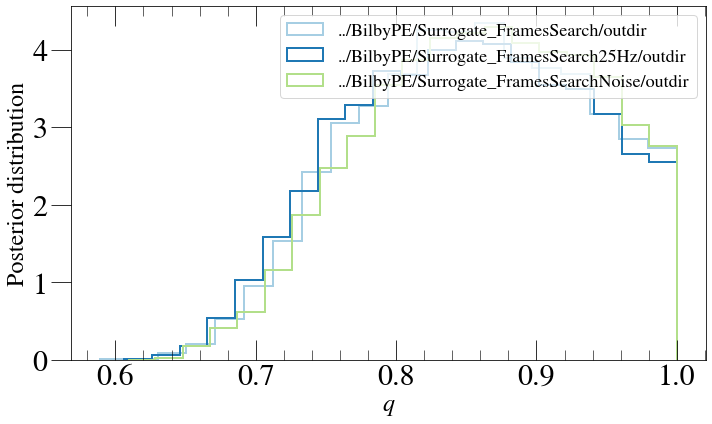

In [185]:
PlotMassRatioPosteriors()

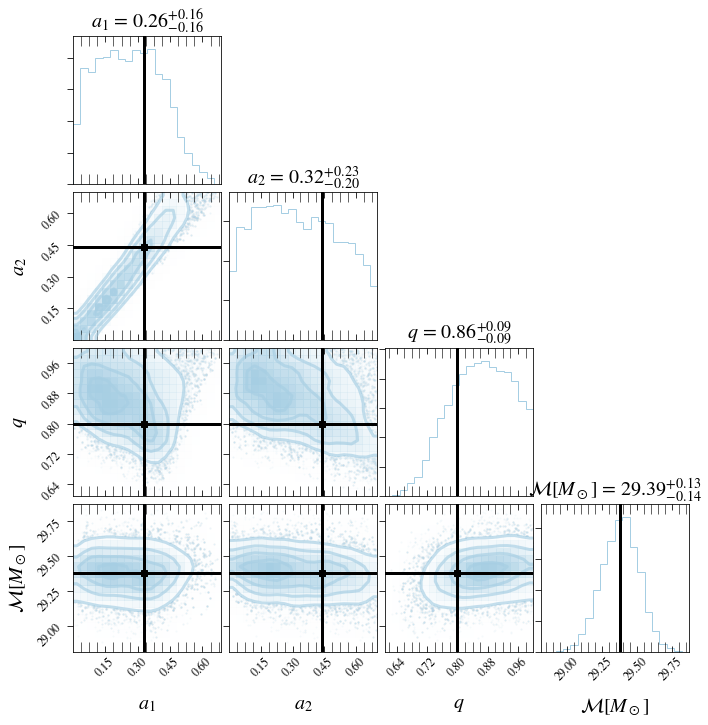

In [190]:
def CornerPlot():
    
    
    p1 = '../BilbyPE/Surrogate_FramesSearchNoise/outdir'
    #p2 = '../BilbyPE/Surrogate/outdir_spin_chirpmassqspin'
    
    quants = ['a_1', 'a_2', 'mass_ratio', 'chirp_mass'] #'mass_ratio', 'chirp_mass'] #, 'a_1', 'a_2']
    labels = [LabelDict[q] for q in quants]
    truths = [TruthDict[q] for q in quants]

    vals1 = np.vstack([GetPosterior(p1, q) for q in quants]).transpose()
    #vals2 = np.vstack([GetPosterior(p2, q) for q in quants]).transpose()
    
    cs = sns.color_palette('Paired', n_colors=10)
    
    ranges = [1.0 for d in labels]
    
    fig, ax_arr = plt.subplots(len(quants),len(quants), figsize=(10,10))

    corner.corner(vals1, fig=fig, labels=labels,
                       title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0], 
                       show_titles=True, truths = truths, truth_color = 'black', smooth = 1.0,)
    #corner.corner(vals2, fig=fig, labels=labels,
    #                   title_kwargs={"fontsize": 18}, label_kwargs={"fontsize": 20}, color=cs[1], 
    #                   show_titles=True, smooth = 1.0)


    ## add in the legend
    #x = [0.0, 0.0]
    #y = [0.0, 0.0]
    #l1 = ax_arr[0].plot(x, y, label='One', color = cs[0])
    #l2 = ax_arr[0].plot(x, y, label='Two', color = cs[1])
    #legend = ax_arr[1].legend(handles=[l1[0], l2[0]], title = '$\ell$', frameon=False)
    #plt.setp(legend.get_title(),fontsize=20)

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('BilbySurrogate.pdf')
    plt.show()
    
CornerPlot()  

In [89]:
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Surrogate_FramesProcs/outdir/fast_tutorial_result.json'

f = open(p)
data = json.load(f)
data.keys()

dict_keys(['label', 'outdir', 'sampler', 'log_evidence', 'log_evidence_err', 'log_noise_evidence', 'log_bayes_factor', 'priors', 'posterior', 'injection_parameters', 'meta_data', 'search_parameter_keys', 'fixed_parameter_keys', 'constraint_parameter_keys', 'sampling_time', 'sampler_kwargs', 'use_ratio', 'information_gain', 'log_likelihood_evaluations', 'log_prior_evaluations', 'samples', 'nested_samples', 'parameter_labels', 'parameter_labels_with_unit', 'version'])